In [ ]:
# !pip install ijson bitsandbytes langchain langchain_huggingface trl
# !pip install dask[dataframe]
# !pip install transformers accelerate datasets peft

import numpy as np
import pandas as pd
import json
import ast
import re
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import dask.dataframe as dd

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from transformers import (pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
                          LlamaForCausalLM, LlamaTokenizer, TrainingArguments, logging,
                          DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, DataCollatorForLanguageModeling)

# import bitsandbytes as bnb
# from langchain import LLMChain
# from langchain.prompts import PromptTemplate
# from langchain_huggingface import HuggingFacePipeline
# from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model
# from trl import SFTTrainer, setup_chat_format

import tensorflow as tf
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Freelance/Fake News Detection/WELFake_Dataset.csv', index_col=0)

In [3]:
df_sampled, _ = train_test_split(df, train_size=20000, stratify=df["label"])

## Data Cleaning

In [4]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 37573 to 55833
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19847 non-null  object
 1   text    19989 non-null  object
 2   label   20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [5]:
df_sampled = df_sampled.dropna(subset=['title', 'text'])

df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19836 entries, 37573 to 55833
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19836 non-null  object
 1   text    19836 non-null  object
 2   label   19836 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 619.9+ KB


In [6]:
df_sampled['combined_text'] = df_sampled['title'] + ' ' + df_sampled['text']

In [7]:
df_sampled = df_sampled.drop(['title', 'text'], axis=1)

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
  """Cleans text by removing URLs, mentions, hashtags, special characters,
  converting to lowercase, removing 'rt', and applying stemming."""
  text = re.sub(r'\bRT\b' , "", text)
  text = re.sub(r'http\S+', '', text)  # Remove URLs
  text = re.sub(r'@\S+', '', text)  # Remove mentions
  text = re.sub(r'#\S+', '', text)  # Remove hashtags
  text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
  return text.strip()

def preprocess_tweet(tweet):
  """Preprocesses a tweet by removing stop words, punctuation,
  and applying stemming."""
  stop_words = set(stopwords.words('english'))
  tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
  tokens = tokenizer.tokenize(tweet)

  stemmer = PorterStemmer()
  filtered_tokens = [stemmer.stem(w) for w in tokens if w not in stop_words and w.isalnum()]
  return " ".join(filtered_tokens)

def clean_and_preprocess(text):
  """Cleans and preprocesses text by removing URLs, mentions, hashtags,
  special characters, converting to lowercase, removing 'rt', and applying
  stemming."""
  text = clean_text(text)
  text = preprocess_tweet(text)
  return text

df_sampled['processed_text'] = df_sampled['combined_text'].apply(clean_and_preprocess)

df_sampled = df_sampled.drop(['combined_text'], axis=1)

df_sampled.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,processed_text
37573,0,princ heel elev style icon new york time febru...
35762,0,hillari clinton email scandal biggest nothingb...
51665,1,assang donald trump wont allow win clinton isi...
22023,1,wow fox report goe seiu thug tell black protes...
65980,0,japan emperor akihito like abdic endmarch 2019...


## EDA


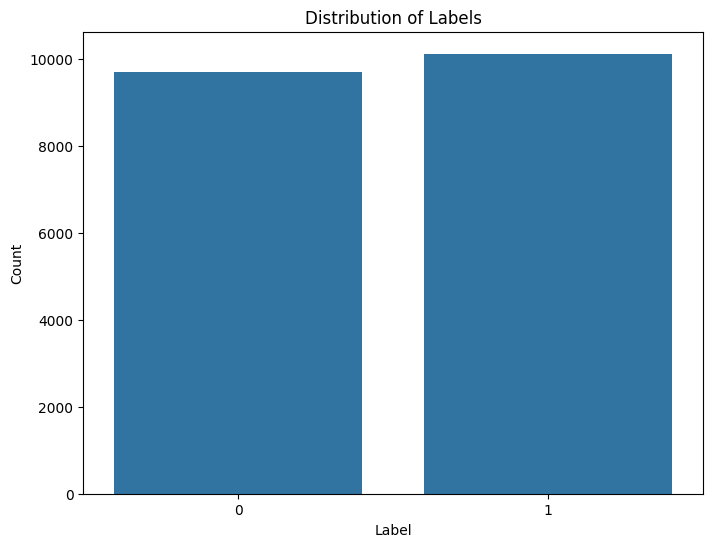

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_sampled)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Modeling


In [11]:
X = df_sampled['processed_text']
y = df_sampled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [12]:
y_train.value_counts()

,count
label,
1,6464
0,6230


### DistilBERT

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train.tolist())
val_dataset = NewsDataset(val_encodings, y_val.tolist())
test_dataset = NewsDataset(test_encodings, y_test.tolist())

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated an

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: balaj-khalid (balaj-khalid-university-of-southern-california) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.169600,0.103945,0.959357
2,0.053200,0.111979,0.973220
3,0.000600,0.116112,0.976686


TrainOutput(global_step=2382, training_loss=0.11872337808171568, metrics={'train_runtime': 1974.6948, 'train_samples_per_second': 19.285, 'train_steps_per_second': 1.206, 'total_flos': 5044623475617792.0, 'train_loss': 0.11872337808171568, 'epoch': 3.0})

In [16]:
predictions = trainer.predict(test_dataset)

predicted_labels = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9818548387096774


In [17]:
model.save_pretrained('/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model')
tokenizer.save_pretrained('/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model')

('/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model/tokenizer_config.json',
 '/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model/special_tokens_map.json',
 '/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model/vocab.txt',
 '/content/drive/MyDrive/Freelance/Fake News Detection/fake_news_model/added_tokens.json')